In [1]:
import pandas as pd
import sys
import os
from ete3 import Tree
import seaborn as sns
sys.path.append("/Users/marc/Desktop/PostDoc/Mutation/signature5/notebooks")
import tools

col_order = ['Chr', 'Pos', 'Ref', 'Alt', 'Sample', 'Tissue_CellType', 'Compartment',
             'Individual', 'Study', 'Context', 'GeneralType', 'Type']
col_meta = ["Study", "Sample", "Individual", "Age", "Compartment", "Status", "Tissue_CellType"]

Read data

In [2]:
meta = pd.read_csv("cell_11495_mmc2.txt", sep="\t")
adj_burdens = meta.set_index("crypt_ID")["adj_snv"].to_dict()

In [3]:
dat0 = pd.read_csv("All_IBD_cohort_mutations_mapped_to_branches.txt",sep="\t")
dat0 = dat0.rename(columns={"SampleID":"Sample", "Patient_ID":"Individual"})
dat1 = pd.read_csv("All_control_cohort_mutations_mapped_to_branches.txt",sep="\t")
dat1 = dat1.rename(columns={"SampleID":"Sample"})
dat1["Individual"] = dat1.Sample.str.split("_").str[0]
dat = pd.concat([dat0, dat1], axis=0)

In [4]:
dat["Tissue_CellType"] = "Colonic_crypt"
dat["Study"] = "Olafsson2020"
dat["Compartment"] = "WGS"
dat["Chr"] = "chr" + dat["Chr"]
dat["Pos"] = dat.Pos.astype(int)
dat = tools.keep_snps(dat).reset_index(drop="True")
#dat = dat[~dat["Chr"].isin(["chrX", "chrY"])]

In [5]:
def rename_tree_nodes(newick_file, indv):
    with open(newick_file, 'r') as f:
        t = Tree(f.read().strip())
    
    name_map = {}
    bls = {}
    i = 1
    
    # Rename terminal nodes (leaves)
    for leaf in t.iter_leaves():
        original_name = leaf.name
        new_name = f"{indv}_{i}"
        leaf.name = new_name
        name_map[new_name] = original_name
        bls[new_name] = leaf.dist
        i += 1
    
    # Rename internal nodes
    for node in t.traverse("preorder"):
        if not node.is_leaf():
            new_name = f"{indv}_{i}"
            if not node.name:  # Handle unnamed nodes
                node.name = new_name
            else:
                name_map[node.name] = new_name
                node.name = new_name
            if node.dist>0:
                bls[new_name] = node.dist
            i += 1
    
    # Return the modified Newick and name mapping
    return t.write(format=1), bls, name_map

def get_terminal_descendants(newick_str):
    t = Tree(newick_str, format=1)
    return {
        node.name: [leaf.name for leaf in node.iter_leaves()]
        for node in t.traverse()
    }


In [6]:
res_l = []
burdens_l = []
ndat_l = []

for indv,df in dat.groupby("Individual"):

    bmuts = df.groupby("Sample").size().sort_index(key=lambda x: x.str.extract('_(\d+)')[0].astype(int)).to_dict()
    tree_file = f"Phylogenetic_trees_SBS/{indv}_MutAssign_unadj.tree"

    if os.path.exists(tree_file)==False:
        print(f"{tree_file} does not exist")
        continue

    new_tree, blen, name_map = rename_tree_nodes(tree_file, indv)
    descendants = get_terminal_descendants(new_tree)
    
    ndf_l = []
    for _,r in df.iterrows():
        for terminal in descendants[r.Sample]:
            r2 = r.copy()
            r2.Sample = terminal
            ndf_l.append(r2)
    ndf = pd.DataFrame(ndf_l)
    ndat_l.append(ndf)

    for t, nndf in ndf.groupby("Sample"):
        if name_map[t] not in adj_burdens:
            print(f"{name_map[t]} not in adj burdens metafile")
        else:
            burdens_l.append([t, len(nndf), adj_burdens[name_map[t]]])

    for k,v in bmuts.items():
        res_l.append([indv, k, v, blen[k]])

res = pd.DataFrame(res_l, columns=["indiv", "branch", "nmuts", "bl"])
res["dif"] = res.bl - res.nmuts

ndat = pd.concat(ndat_l)
burdens = pd.DataFrame(burdens_l, columns=["Sample", "nmuts", "adj_burden"])

PD36814m5 not in adj burdens metafile
PD37265m3 not in adj burdens metafile
PD37226o5 not in adj burdens metafile
PD37265m4 not in adj burdens metafile
PD36814m8 not in adj burdens metafile
PD37226o4 not in adj burdens metafile
PD37226j4 not in adj burdens metafile
PD37226j8 not in adj burdens metafile
PD37226p7 not in adj burdens metafile
PD37226j5 not in adj burdens metafile
PD37226j6 not in adj burdens metafile
PD37226j7 not in adj burdens metafile
PD34200a_i33 not in adj burdens metafile
PD34200a_i21 not in adj burdens metafile
PD34200a_i22 not in adj burdens metafile
PD34200a_i36 not in adj burdens metafile
PD34200a_i54 not in adj burdens metafile
PD37266c_lo0010 not in adj burdens metafile
PD37266c_lo0012 not in adj burdens metafile
PD37266c_lo0014 not in adj burdens metafile
PD37266c_lo0016 not in adj burdens metafile
PD37266c_lo0023 not in adj burdens metafile
PD37266c_lo0018 not in adj burdens metafile
PD37449f_lo0002 not in adj burdens metafile
PD37449f_lo0010 not in adj burd

<Axes: xlabel='dif', ylabel='Count'>

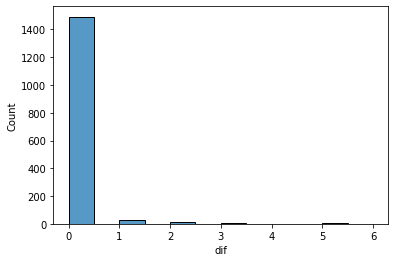

In [8]:
sns.histplot(res.dif)

In [9]:
ndat = ndat[~ndat["Chr"].isin(["chrX", "chrY"])]
cosmic = tools.COSMIC()
ndat = tools.annotate_context(ndat, "../fasta/hg19.fa")
ndat = ndat.assign(GeneralType=tools.annotate_general_type(ndat))
ndat['Type'] = cosmic.fold(ndat['GeneralType'])

In [16]:
ndat = ndat[col_order]
ndat.to_csv("Olafsson2020.csv.gz",index=False)

Metafile

In [148]:
meta0 = pd.read_excel("1-s2.0-S0092867420308138-mmc1.xlsx",skiprows=2)

In [83]:
meta0 = meta0.rename(columns = {"patient_ID":"Individual", "Disease":"Status", "Sequencing_type":"Compartment"})

In [84]:
nodes = list(dat.Sample.unique())

In [85]:
meta = pd.DataFrame([nodes, [n.split("_")[0] for n in nodes]]).transpose()
meta.columns = ["Sample", "Individual"]

In [86]:
meta = meta.set_index("Individual").join(meta0.set_index("Individual")).reset_index()

In [53]:
meta["Study"] = "Olafsson2020"
meta["Tissue_CellType"] = "Colonic_crypt"

In [55]:
meta[col_meta].to_csv("Olafsson2020.tab.gz",sep="\t")